# **Packages**  

In [73]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error as MSE

# **Downloading the samples**

In [74]:
with open("400_samples_for_model.pkl","rb") as f:
    amazon_samples400 = pickle.load(f)

print(amazon_samples400.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 67 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Agent_Age                          400 non-null    float64
 1   Agent_Rating                       400 non-null    float64
 2   Drop_Latitude                      400 non-null    float64
 3   Drop_Longitude                     400 non-null    float64
 4   Distance_Store_Drop_km             400 non-null    float64
 5   abs_Store_Latitude                 400 non-null    float64
 6   abs_Store_Longitude                400 non-null    float64
 7   Order_weekday                      400 non-null    float64
 8   Order_Time_hour                    400 non-null    float64
 9   Pickup_hour                        400 non-null    float64
 10  Delivery_Time                      400 non-null    int64  
 11  Young_vs_Older_Agents              400 non-null    int32  

# **Splitting data**

In [75]:
X= amazon_samples400.drop("Delivery_Time", axis=1)
y=amazon_samples400["Delivery_Time"]

In [76]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1984)


# **Finding the best model**  


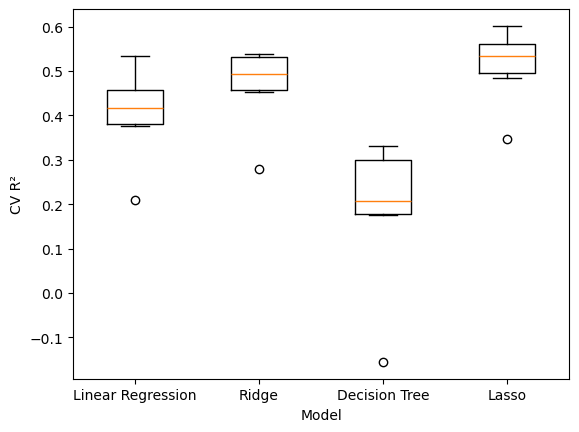

In [77]:
LinearReg = LinearRegression()
DecTree = DecisionTreeRegressor(max_depth=33, min_samples_leaf=0.05, max_features="sqrt", random_state=2013)
ridge = Ridge(alpha=0.1)
lasso = Lasso(alpha = 0.1)

models = {"Linear Regression":LinearReg, "Ridge":ridge, "Decision Tree":DecTree, "Lasso":lasso}

from modules import visu_cv_score

visu_cv_score(models,X_train,y_train)


In [78]:
from modules import rmse_regression_models

rmse_regression_models(models,X_train,y_train,X_test,y_test)

Linear Regression Test set rmse: 39.46887034200775
Ridge Test set rmse: 39.51343421424932
Decision Tree Test set rmse: 49.51442762201243
Lasso Test set rmse: 38.53096960784252


Although none of them are at this stage great, Lasso would be the best algorithm to tune.

# **Lasso hyperparamater tuning**

# **Model with no cities**

In [79]:
with open("400samples_noCities.pkl","rb") as f:
    samples_noCities = pickle.load(f)

In [80]:
samples_noCities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Agent_Age               400 non-null    float64
 1   Agent_Rating            400 non-null    float64
 2   Drop_Latitude           400 non-null    float64
 3   Drop_Longitude          400 non-null    float64
 4   Distance_Store_Drop_km  400 non-null    float64
 5   abs_Store_Latitude      400 non-null    float64
 6   abs_Store_Longitude     400 non-null    float64
 7   Order_weekday           400 non-null    float64
 8   Order_Time_hour         400 non-null    float64
 9   Pickup_hour             400 non-null    float64
 10  Delivery_Time           400 non-null    int64  
 11  Young_vs_Older_Agents   400 non-null    int32  
 12  Grocery_vs_not          400 non-null    int32  
 13  Weather_Cloudy          400 non-null    bool   
 14  Weather_Fog             400 non-null    bo

In [81]:
numerical_features = samples_noCities[["Agent_Age","Agent_Rating","Distance_Store_Drop_km","Order_weekday",\
                                       "Order_Time_hour","Pickup_hour","Drop_Latitude","Drop_Longitude",\
                                        "abs_Store_Latitude","abs_Store_Longitude"]]

print(numerical_features.corr())


                        Agent_Age  Agent_Rating  Distance_Store_Drop_km  \
Agent_Age                1.000000     -0.091737                0.003242   
Agent_Rating            -0.091737      1.000000               -0.087349   
Distance_Store_Drop_km   0.003242     -0.087349                1.000000   
Order_weekday            0.012985     -0.013691                0.107052   
Order_Time_hour          0.050347     -0.092842                0.566868   
Pickup_hour              0.039450     -0.090907                0.465678   
Drop_Latitude            0.033723      0.059967               -0.030055   
Drop_Longitude           0.045485      0.042194                0.000979   
abs_Store_Latitude       0.033695      0.060523               -0.036534   
abs_Store_Longitude      0.045440      0.043125               -0.009843   

                        Order_weekday  Order_Time_hour  Pickup_hour  \
Agent_Age                    0.012985         0.050347     0.039450   
Agent_Rating                -0.0

In [82]:
samples_noCities = samples_noCities.drop(["Order_Time_hour","abs_Store_Latitude","abs_Store_Longitude"], axis=1)

In [83]:
X_noC = samples_noCities.drop("Delivery_Time", axis=1)
y_noC = samples_noCities["Delivery_Time"]

X_noC_train,X_noC_test,y_noC_train,y_noC_test = train_test_split(X_noC,y_noC,test_size=0.25,random_state=1984)


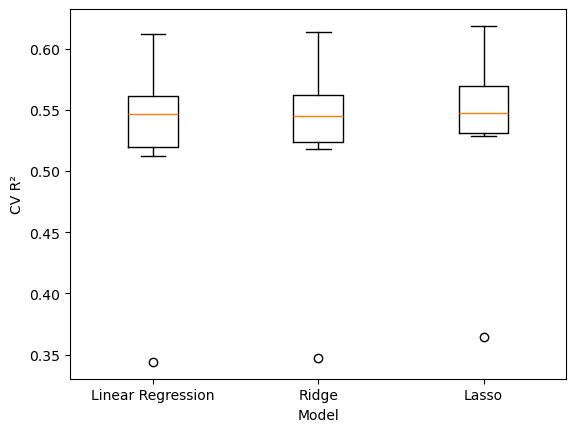

In [84]:
decTreeC = DecisionTreeRegressor(max_depth=20, min_samples_leaf=0.05, max_features="sqrt")
new_models = {"Linear Regression":LinearReg, "Ridge":ridge, "Lasso":lasso}
visu_cv_score(new_models,X_noC_train,y_noC_train)

In [85]:
rmse_regression_models(new_models,X_noC_train,y_noC_train,X_noC_test,y_noC_test)

Linear Regression Test set rmse: 37.535728901407836
Ridge Test set rmse: 37.52061563997393
Lasso Test set rmse: 37.246612014467495


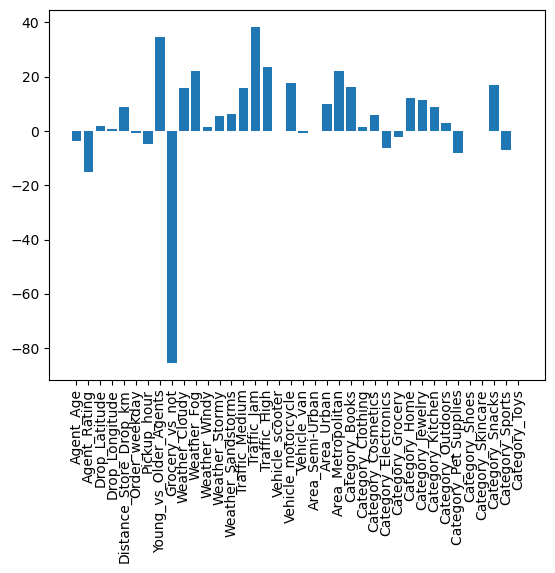

In [86]:
lasso.fit(X_noC_train,y_noC_train)

coef = lasso.coef_
columns = X_noC.columns
plt.bar(x=columns, height=coef)
plt.xticks(rotation=90)
plt.show()

# **Hyperparameter tuning of Lasso**

In [87]:
scores=[]
alphas_list = np.linspace(0,1,num=20)
for alpha in alphas_list:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_noC_train,y_noC_train)
    lasso_pred = lasso.predict(X_noC_test)
    scores.append(MSE(y_noC_test,lasso_pred)**(1/2))

print(scores)

[37.53572890140785, 37.354812106717645, 37.233898515134385, 37.14169403234932, 37.050185651816015, 36.9571644787044, 36.88526933109233, 36.849748997224694, 36.87991215209081, 36.907402664287545, 36.94012888815839, 37.0011143812093, 37.085826465373955, 37.19583928307383, 37.32743566721608, 37.47069123067155, 37.625469601060594, 37.79164986007997, 37.96908876658995, 38.16752721584309]


c:\Users\Angelique\anaconda3\envs\Essai\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\Angelique\anaconda3\envs\Essai\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Angelique\anaconda3\envs\Essai\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.293e+05, tolerance: 7.606e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/Ridg

In [88]:
lasso_scores_alphas = pd.DataFrame(scores, index=alphas_list)
print(lasso_scores_alphas)

                  0
0.000000  37.535729
0.052632  37.354812
0.105263  37.233899
0.157895  37.141694
0.210526  37.050186
0.263158  36.957164
0.315789  36.885269
0.368421  36.849749
0.421053  36.879912
0.473684  36.907403
0.526316  36.940129
0.578947  37.001114
0.631579  37.085826
0.684211  37.195839
0.736842  37.327436
0.789474  37.470691
0.842105  37.625470
0.894737  37.791650
0.947368  37.969089
1.000000  38.167527


In [89]:
best_alpha = 0.368421
best_regr = Lasso(alpha=best_alpha)
best_regr.fit(X_noC_train,y_noC_train)

Lasso(alpha=0.368421)

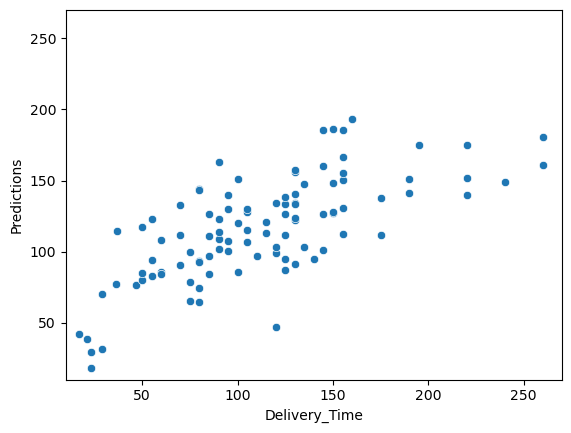

In [96]:
y_predict = best_regr.predict(X_noC_test)

sns.scatterplot(x=y_noC_test, y=y_predict)
plt.xlim(10,270)
plt.ylim(10,270)
plt.ylabel("Predictions")
plt.show()

In [91]:
comparison = pd.DataFrame({"Delivery_Time":y_noC_test, "Predictions_Del_Time":y_predict})
print(comparison.corr())

                      Delivery_Time  Predictions_Del_Time
Delivery_Time              1.000000              0.704898
Predictions_Del_Time       0.704898              1.000000


In [93]:
comparison.head(20)

,Delivery_Time,Predictions_Del_Time
254,150,186.126168
82,90,123.297740
309,90,163.058711
341,80,143.841897
262,130,140.285631
53,95,107.624404
145,60,107.888099
113,155,166.458571
173,95,139.946633
269,21,38.255808
